In [1]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Input, Conv2D, BatchNormalization, MaxPool2D, Flatten, Dropout
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.optimizers import RMSprop, SGD, Adam, Adagrad, Adadelta, Adamax, Nadam, Optimizer
import matplotlib.pyplot as plt
from typing import List, Union
import sys
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
tf.config.get_logical_device_configuration

<function tensorflow.python.framework.config.get_logical_device_configuration(device)>

In [ ]:
print(tf.config.list_physical_devices('GPU'))

[]


In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [4]:
train_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ml-leran/Digit Recognizer/data/train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ml-leran/Digit Recognizer/data/test.csv')
print('Shape:',train_data.shape)
train_data.head()

Shape: (42000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


##Normalization

In [ ]:
Y_train = train_data['label'].values
X_train = train_data.drop(columns=['label']).values / 255.0
X_test = test_data.values / 255.0

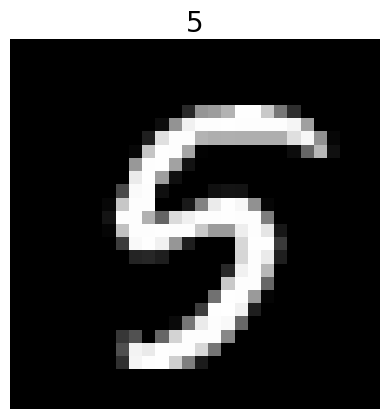

In [ ]:
plt.imshow(X_train[8, :].reshape(28, 28), cmap='gray')
plt.axis('off')  # Nobody cares about the axes :(
label = Y_train[8]  # The actual label for this data
plt.title(label, fontsize=20)
plt.show()

# Convolutional Neural Network

In [ ]:
def build_cnn():
    model = Sequential(name='CNN')

    # Conv + Batch norm + Conv + MaxPool + Dropout
    model.add(Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='relu',
                    input_shape=(28, 28, 1)))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))  # Downscale
    model.add(Dropout(rate=.25))

    # Conv + Batch norm + Conv + MaxPool + Dropout
    model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))  # Downscale
    model.add(Dropout(rate=.25))

    # Flatten + Dense + D ropout + Dense (output)
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=.5))
    model.add(Dense(10, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=.2, patience=5, min_lr=1e-5, verbose=1)

In [ ]:
seed=0
Y_train = to_categorical(Y_train, num_classes=10)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=.2, random_state=seed)

In [ ]:
cnn_model = build_cnn()
X_train_img = X_train.reshape(-1, 28, 28, 1)
X_val_img = X_val.reshape(-1, 28, 28, 1)
X_test_img = X_test.reshape(-1, 28, 28, 1)
# plot_model(cnn_model, to_file='cnn_model.png', show_shapes=True)

In [ ]:
# cnn_model.fit(X_train_img, Y_train, epochs=10, validation_data=(X_val_img, Y_val), verbose=0)

In [ ]:
# cnn_model.evaluate(X_val_img, Y_val)

In [ ]:
# cnn_model.save('cnn_model.h5')

In [ ]:
epochs = 50
datagen = ImageDataGenerator(
    rotation_range=10,  # Randomly rotate image within range
    zoom_range = 0.1,  # Randomly zoom in/out
    width_shift_range=0.1,  # Shift (fraction of total)
    height_shift_range=0.1,  # Shift (fraction of total)
)
datagen.fit(X_train_img)

In [ ]:
cnn_model_datagen = build_cnn()

In [ ]:
history = cnn_model_datagen.fit(datagen.flow(X_train_img, Y_train, batch_size=64),
                                         epochs=epochs, steps_per_epoch=X_train_img.shape[0]//64,
                                         validation_data=(X_val_img, Y_val),
                                         callbacks=[reduce_lr],
                                         verbose=0)

In [ ]:
cnn_model_datagen.evaluate(X_val_img, Y_val)

263/263 [==============================] - 19s 73ms/step - loss: 0.0330 - accuracy: 0.9894


[0.03300926834344864, 0.9894047379493713]

In [ ]:
cnn_model_datagen.save('cnn_model_best.h5')

In [ ]:
model = load_model('/content/drive/MyDrive/Colab Notebooks/ml-leran/Digit Recognizer/cnn_model_best.h5')

In [ ]:
np.argmax(model.predict(X_val_img)[7])

263/263 [==============================] - 20s 74ms/step


0

In [ ]:
Y_val[9]

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)